# Predicting House Sale Prices in Ames

In this project, we will use the [housing data](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) for the city of Ames, Iowa, United States from 2006 to 2010 to predict the housing prices. More information about the data can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt). In addition, we will set up a pipeline of functions to iterate on different models, which contains the below 3 parts:

- transform_features
- select_features
- train_and_test

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

In [2]:
housing = pd.read_csv('AmesHousing.tsv', '\t')
print(housing.shape)
housing.head(3)

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [3]:
train = housing.copy()

## 1.Transform features

First of all, we will remove features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns.

### 1.1 Missing Value

The below columns have a number of missing values. Considering that our data set has 2930 rows, columns like `Alley` and `Pool QC` have more than half of the data are missing. We will drop the columns if the percentage of missing value is higher than a certain level. The default level is set to be 5%.

In [4]:
# count missing value for each column
missing_value = train.isnull().sum()
missing_value[missing_value>0]

Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

In [54]:
# columns with less than 5% missing values
missing = 0.05*len(train)

no_missing_col = missing_value[missing_value==0]
no_missing_train = train[no_missing_col.index]

low_missing_col = missing_value[(missing_value<missing)&(missing_value>0)]
low_missing_train = train[low_missing_col.index]

print('Dropped columns:\n', missing_value[missing_value>=missing].index)

Dropped columns:
 Index(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')


We will fill those numerical columns with few missing values (<5%) with the most popular value. For those categorical columns, we will fill *None*.

In [55]:
for col in low_missing_col.index:
    print(col)
    print(low_missing_train[col].value_counts(dropna=False).head())
    print('----------')

Mas Vnr Type
None       1752
BrkFace     880
Stone       249
BrkCmn       25
NaN          23
Name: Mas Vnr Type, dtype: int64
----------
Mas Vnr Area
 0.0      1748
NaN         23
 120.0      15
 200.0      13
 176.0      13
Name: Mas Vnr Area, dtype: int64
----------
Bsmt Qual
TA     1283
Gd     1219
Ex      258
Fa       88
NaN      80
Name: Bsmt Qual, dtype: int64
----------
Bsmt Cond
TA     2616
Gd      122
Fa      104
NaN      80
Po        5
Name: Bsmt Cond, dtype: int64
----------
Bsmt Exposure
No     1906
Av      418
Gd      284
Mn      239
NaN      83
Name: Bsmt Exposure, dtype: int64
----------
BsmtFin Type 1
GLQ    859
Unf    851
ALQ    429
Rec    288
BLQ    269
Name: BsmtFin Type 1, dtype: int64
----------
BsmtFin SF 1
0.0      930
24.0      27
16.0      14
300.0      9
288.0      8
Name: BsmtFin SF 1, dtype: int64
----------
BsmtFin Type 2
Unf    2499
Rec     106
LwQ      89
NaN      81
BLQ      68
Name: BsmtFin Type 2, dtype: int64
----------
BsmtFin SF 2
0.0      2578
294.

In [56]:
low_missing_train_num = low_missing_train.select_dtypes(exclude=['object']).copy()
low_missing_train_obj = low_missing_train.select_dtypes('object').copy()

low_missing_train_num.fillna(low_missing_train_num.mode().iloc[0], inplace=True)
low_missing_train_obj.fillna('None', inplace=True)

# combine columns
clean_missing_train = pd.concat([no_missing_train,
                                 low_missing_train_num,
                                 low_missing_train_obj],
                                axis = 1)

### 1.2 Feature transformation

We will use some new features to provide more informative details.

- `remod_age_at_sold`: `Yr Sold` - `Year Remod/Add`, To estimate the price if we sell the apartment after the years of remodification.
- `apartment_age_at_sold`: `Yr Sold` - `Year Built`. To estimate the price if we sell the apartment at the current age.

In [8]:
clean_missing_train['remod_age_at_sold'] = clean_missing_train['Yr Sold']-clean_missing_train['Year Remod/Add']
clean_missing_train['apartment_age_at_sold'] = clean_missing_train['Yr Sold']-clean_missing_train['Year Built']

There are some negative numbers in the newly created columns. We can assume that they are sold before the construction finished. We better drop these rows.

In [57]:
print(clean_missing_train['remod_age_at_sold'][clean_missing_train['remod_age_at_sold']<0])
print(clean_missing_train['apartment_age_at_sold'][clean_missing_train['apartment_age_at_sold']<0])

KeyError: 'remod_age_at_sold'

In [58]:
clean_missing_train = clean_missing_train.drop([1702,2180,2181], axis=0)

### 1.3 Information leak and reductant columns
`Mo Sold`, `Yr Sold`, `Sale Type` and `Sale Condition` are the columns leaking information about the sale. On the other hand, we have already extract information from `Year Remod/Add` and `Year Built`. `Order` and `PID` are redundant columns. All these columns should be dropped.

In [59]:
drop_col = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition',
            'Year Remod/Add', 'Year Built',
            'Order', 'PID']

clean_train = clean_missing_train.drop(
    drop_col,
    axis = 1
)

In [60]:
def transform_features(data):
    
    clean_data = data.copy()
    # count missing value for each column
    missing_value = clean_data.isnull().sum()
    
    # columns with less than 5% missing values
    missing = 0.05*len(clean_data)

    no_missing_col = missing_value[missing_value==0]
    no_missing_train = clean_data[no_missing_col.index]

    low_missing_col = missing_value[(missing_value<missing)&(missing_value>0)]
    low_missing_train = clean_data[low_missing_col.index]
    
    # fill missing value by spliting numerical and categorical features
    low_missing_train_num = low_missing_train.select_dtypes(exclude=['object']).copy()
    low_missing_train_obj = low_missing_train.select_dtypes('object').copy()

    low_missing_train_num.fillna(low_missing_train_num.mode().iloc[0], inplace=True)
    low_missing_train_obj.fillna('None', inplace=True)

    # combine columns
    clean_missing_train = pd.concat([
        no_missing_train,
        low_missing_train_num,
        low_missing_train_obj
    ], axis = 1)
    
    # new features, 'remod_age_at_sold' & 'apartment_age_at_sold'
    clean_missing_train['remod_age_at_sold'] = clean_missing_train['Yr Sold']-clean_missing_train['Year Remod/Add']
    clean_missing_train['apartment_age_at_sold'] = clean_missing_train['Yr Sold']-clean_missing_train['Year Built']
    
    # drop rows with invalid values
    clean_missing_train = clean_missing_train.drop([1702,2180,2181], axis=0)
      
    # drop columns with infomration leak, reduntant
    drop_col = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition',
                'Year Remod/Add', 'Year Built',
                'Order', 'PID']

    clean_train = clean_missing_train.drop(drop_col, axis = 1)

    return clean_train

## 2. features selection

We will use the below criteria to select our features in order to reduce the dimensions and improve efficiency:

1. numerical features with strong absolute correlation with `SalePrice` (>0.3)
2. grouping diverse categorical column
3. remove low variance features
4. remove strongly correlated categorical features

Before selecting the features, we have to make sure they have the correct types. After studying the details of each column, we can group the features into the below types:
       
- **ordinal**: 'Lot Shape', 'Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual', 'Functional', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Paved Drive', 'Electrical'

- **norminal**: 'MS SubClass', 'MS Zoning', 'Land Contour','Lot Config', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Foundation', 'Central Air', 'Mas Vnr Area', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Condition 1', 'Exterior 1st', 'Exterior 2nd', 'Utilities','Land Slope', 'Condition 2', 'Roof Matl', 'Heating', 'Low Qual Fin SF', 'Kitchen AbvGr' & '3Ssn Porch'

- **numerical**: rest of the columns 

In [61]:
# ordinal columns
ord_col = ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual', 
           'Bsmt Qual', 'Bsmt Cond']

# nominal columns
nor_col = ['Lot Shape', 'MS SubClass', 'MS Zoning', 'Functional', 
           'Land Contour','Lot Config', 'Neighborhood', 'Bldg Type', 
           'House Style', 'Roof Style', 'Foundation', 'Central Air', 
           'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Exposure', 
           'Paved Drive', 'Mas Vnr Type', 'Electrical', 'Street',
           'Condition 1', 'Exterior 1st', 'Exterior 2nd', 'Utilities',
           'Land Slope', 'Condition 2', 'Roof Matl', 'Heating', 
           'Low Qual Fin SF', 'Kitchen AbvGr', '3Ssn Porch']

# all non-numerical columns
non_num_col = ord_col.copy()
non_num_col.extend(nor_col)
clean_train[non_num_col] = clean_train[non_num_col].astype('object')

# numerical columns
num_col = [col for col in clean_train.columns if col not in non_num_col]

### 2.1 Correlation with `SalePrice`

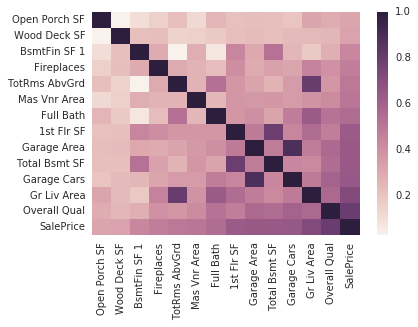

In [62]:
# Correlationship with SalePrice for numerical features
sorted_corrs = clean_train[num_col].corr()['SalePrice'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs>0.3].index
corrmat = clean_train[strong_corrs].corr()
sns.heatmap(corrmat)

The pairs, (`Gr Liv Area`, `TotRms AbvGrd`), (`Total Bsmt SF`, `1st Flr SF`) and (`Garage Area`, `Garage Cars`) have a very strong correlation with each other. Therefore we can choose one feature from each pair and drop the other one. The features to be drop are `TotRms AbvGrd`, `Total Bsmt SF` and `Garage Cars` since they provide less useful information than the other in general. 

In [15]:
selected_train_num_col = strong_corrs.drop(['TotRms AbvGrd',
                                            'Total Bsmt SF',
                                            'Garage Cars'])

### 2.2 Categorical features diversity

We will focus on those features with more than 10 unique values.

In [16]:
clean_train[non_num_col].nunique().sort_values(ascending = False).head(5)

Low Qual Fin SF    36
3Ssn Porch         31
Neighborhood       28
Exterior 2nd       17
MS SubClass        16
dtype: int64

In [17]:
high_diversity_features = clean_train[non_num_col].nunique().sort_values(ascending = False).head(4).index

for col in high_diversity_features:
    print('Top 5 proportion in', col)
    print(clean_train[col].value_counts(normalize=True).head().sum(), '\n')

print('Neighborhood counts:')
print(clean_train['Neighborhood'].value_counts(normalize=True))

Top 5 proportion in Low Qual Fin SF
0.9894089511445165 

Top 5 proportion in 3Ssn Porch
0.9907755380936112 

Top 5 proportion in Neighborhood
0.4519986334130509 

Top 5 proportion in Exterior 2nd
0.8670994192005466 

Neighborhood counts:
NAmes      0.151350
CollgCr    0.091220
OldTown    0.081654
Edwards    0.065596
Somerst    0.062180
NridgHt    0.056372
Gilbert    0.056372
Sawyer     0.051589
NWAmes     0.044756
SawyerW    0.042706
Mitchel    0.038948
BrkSide    0.036898
Crawfor    0.035190
IDOTRR     0.031773
Timber     0.024599
NoRidge    0.024257
StoneBr    0.017424
SWISU      0.016399
ClearCr    0.015032
MeadowV    0.012641
BrDale     0.010249
Blmngtn    0.009566
Veenker    0.008200
NPkVill    0.007858
Blueste    0.003416
Greens     0.002733
GrnHill    0.000683
Landmrk    0.000342
Name: Neighborhood, dtype: float64


We will keep the top 5 values in `Exterior 2nd`, `MS SubClass` and `Exterior 1st` as they contain more than 70% of the values. The rest will be set as *other*.  `Neighborhood` will be dropped because it has too many unique values and their distributions are quite even.

In [63]:
for col in high_diversity_features[1:]:
    # list of values to be kept
    remain_value = clean_train[col].value_counts().head(5).index
    # replace remaining values as 'other'
    clean_train[col] = np.where(
        clean_train[col].isin(remain_value), 
        clean_train.loc[clean_train.index][col], 
        'other'
    )
    # check new columns
    print(clean_train[col].value_counts())

0        2890
other      27
168         3
153         3
180         2
144         2
Name: 3Ssn Porch, dtype: int64
other      1604
NAmes       443
CollgCr     267
OldTown     239
Edwards     192
Somerst     182
Name: Neighborhood, dtype: int64
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     397
other       389
Plywood     274
Name: Exterior 2nd, dtype: int64


### 2.3 Low variance features

Features with a very high proportion of the same value (>95%) can provide very little information to the model. These features will be dropped.

In [64]:
# columns with a huge number of common values
common_values_col = []
for col in clean_train.columns:
    perc_most_freq_value = len(clean_train[clean_train[col] == clean_train[col].mode()[0]])/len(clean_train)
    if  perc_most_freq_value> 0.95:
        print(col, perc_most_freq_value)
        common_values_col.append(col)

Street 0.9959002391527161
Utilities 0.998975059788179
Land Slope 0.9518278100444141
Condition 2 0.9900922446190639
Roof Matl 0.9853091902972326
Heating 0.9846258968226853
Low Qual Fin SF 0.9863341305090536
Kitchen AbvGr 0.9542193372053297
3Ssn Porch 0.9873590707208746
Pool Area 0.9955585924154424
Misc Val 0.9651520327980868


In [65]:
clean_train = clean_train.drop(common_values_col,axis = 1)
non_num_col = list(set(non_num_col).intersection(clean_train.columns))

### 2.4 Categorical features importance

Since there are hundreds of categorical columns after we create the dummy variables, we have to reduce the dimension by check the importance of each column. We will use Extra Trees to achieve this goal.

Before we start the calculation, we have to assign numerical values for the ordinal features and create dummy columns for nominal features.

In [66]:
clean_ord_col = pd.DataFrame()

# set order
cat_type = CategoricalDtype(
    categories=["None", "Po", "Fa", "TA", "Gd", "Ex"], 
    ordered=True
)

# assign ordinal object type
for col in ord_col:
    clean_ord_col[col] = clean_train[col].astype(cat_type)
    clean_train[col] = clean_ord_col[col].cat.codes

In [67]:
list(set(nor_col).intersection(clean_train.columns))

['Lot Config',
 'Land Contour',
 'MS Zoning',
 'Lot Shape',
 'Neighborhood',
 'Mas Vnr Type',
 'Central Air',
 'House Style',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Foundation',
 'Paved Drive',
 'Exterior 2nd',
 'Functional',
 'Exterior 1st',
 'Roof Style',
 'MS SubClass',
 'Bldg Type',
 'Condition 1',
 'Electrical',
 'Bsmt Exposure']

In [68]:
# assign dummy columns
nor_col = list(set(nor_col).intersection(clean_train.columns))
clean_nor_col = pd.get_dummies(clean_train[nor_col],
                              prefix = nor_col)
clean_all_train = pd.concat([clean_train,clean_nor_col], axis = 1)

non_num_col = ord_col.copy()
non_num_col.extend(clean_nor_col.columns)

In [24]:
nor_col

['Lot Config',
 'Land Contour',
 'MS Zoning',
 'Lot Shape',
 'Neighborhood',
 'Mas Vnr Type',
 'Central Air',
 'House Style',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Foundation',
 'Paved Drive',
 'Exterior 2nd',
 'Functional',
 'Exterior 1st',
 'Roof Style',
 'MS SubClass',
 'Bldg Type',
 'Condition 1',
 'Electrical',
 'Bsmt Exposure']

In [25]:
# Feature Importance with Extra Trees Classifier
X = clean_all_train[non_num_col].values
Y = clean_train['SalePrice'].values

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
importance = model.feature_importances_.tolist()
importance_table = pd.DataFrame(index = non_num_col, 
                                data = importance)
importance_table.columns = ['importance']
importance_table.sort_values(by='importance', ascending = False).head(20)

,importance
Heating QC,0.047247
Kitchen Qual,0.034765
Bsmt Qual,0.033230
Lot Config_Inside,0.027182
Bsmt Exposure_No,0.023159
BsmtFin Type 1_Unf,0.023015
Exter Qual,0.022862
Lot Shape_IR1,0.021932
Lot Config_Corner,0.021659
Exter Cond,0.020872


Most of the features are not important to predict `SalePrice`. We will only keep the features with importance >0.01.

In [26]:
selected_train_cat_col = importance_table[importance_table['importance'] > 0.01].index

In [27]:
# combine all columns
selected_clean_train = pd.concat([clean_all_train[selected_train_cat_col], 
                         clean_train[selected_train_num_col]],
                         axis = 1)

# columns of the final train data
selected_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 48 columns):
Exter Qual               2927 non-null int8
Exter Cond               2927 non-null int8
Heating QC               2927 non-null int8
Kitchen Qual             2927 non-null int8
Bsmt Qual                2927 non-null int8
Bsmt Cond                2927 non-null int8
Lot Config_Corner        2927 non-null uint8
Lot Config_Inside        2927 non-null uint8
Land Contour_Lvl         2927 non-null uint8
Lot Shape_IR1            2927 non-null uint8
Lot Shape_Reg            2927 non-null uint8
Neighborhood_other       2927 non-null uint8
Mas Vnr Type_BrkFace     2927 non-null uint8
Mas Vnr Type_None        2927 non-null uint8
House Style_1Story       2927 non-null uint8
House Style_2Story       2927 non-null uint8
BsmtFin Type 1_ALQ       2927 non-null uint8
BsmtFin Type 1_BLQ       2927 non-null uint8
BsmtFin Type 1_GLQ       2927 non-null uint8
BsmtFin Type 1_Rec       2927 non-null uint8

In [28]:
def select_features(selected_data):
    
    data = selected_data.copy()
    
    ## features types
    # ordinal columns
    ord_col = ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual', 
           'Bsmt Qual', 'Bsmt Cond']

    # nominal columns
    nor_col = ['Lot Shape', 'MS SubClass', 'MS Zoning', 'Functional', 
               'Land Contour','Lot Config', 'Neighborhood', 'Bldg Type', 
               'House Style', 'Roof Style', 'Foundation', 'Central Air', 
               'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Exposure', 
               'Paved Drive', 'Mas Vnr Type', 'Electrical', 'Street',
               'Condition 1', 'Exterior 1st', 'Exterior 2nd', 'Utilities',
               'Land Slope', 'Condition 2', 'Roof Matl', 'Heating', 
               'Low Qual Fin SF', 'Kitchen AbvGr', '3Ssn Porch']

    # all non-numerical columns
    non_num_col = ord_col.copy()
    non_num_col.extend(nor_col)
    data[non_num_col] = data[non_num_col].astype('object')

    # numerical columns
    num_col = [col for col in data.columns if col not in non_num_col]
    
    ### selecting numerical features
    # keep numerical features with absolute correlation with SalePrice > 0.3
    sorted_corrs = data[num_col].corr()['SalePrice'].abs().sort_values()
    strong_corrs = sorted_corrs[sorted_corrs>0.3].index
    
    selected_train_num_col = strong_corrs.drop(['TotRms AbvGrd',
                                                'Total Bsmt SF',
                                                'Garage Cars'])
    
    # selected numerical features
    selected_train_num = data[selected_train_num_col]
    
    ### selecting categorical features
    ## assign 'other' for high diversity features except top 5 objects
    high_diversity_features = data[non_num_col].nunique().sort_values(ascending = False).head(4).index
    
    for col in high_diversity_features[1:]:
        # list of values to be kept
        remain_value = data[col].value_counts().head(5).index
        # replace remaining values as 'other'
        data[col] = np.where(
            data[col].isin(remain_value), 
            data.loc[data.index][col], 
            'other'
        )
        
    selected_train_cat = data.drop(common_values_col, axis = 1)
    
    ## transform ordinal data
    clean_ord_col = pd.DataFrame()

    # set order
    cat_type = CategoricalDtype(
        categories=["None", "Po", "Fa", "TA", "Gd", "Ex"], 
        ordered=True
    )

    # assign ordinal object type
    for col in ord_col:
        clean_ord_col[col] = data[col].astype(cat_type)
        data[col] = clean_ord_col[col].cat.codes
        
    # update norminal features list
    nor_col = list(set(nor_col).intersection(selected_train_cat.columns))
    # assign dummy columns
    clean_nor_col = pd.get_dummies(data[nor_col],
                                   prefix = nor_col)
    clean_train_cat = pd.concat([data[ord_col],
                                 clean_nor_col], axis = 1)
           
    # Feature Importance with Extra Trees Classifier
    X = clean_train_cat.values
    Y = data['SalePrice'].values

    # feature extraction
    model = ExtraTreesClassifier(n_estimators=10)
    model.fit(X, Y)
    importance = model.feature_importances_.tolist()
    importance_table = pd.DataFrame(index = clean_train_cat.columns, 
                                    data = importance)
    importance_table.columns = ['importance']
    
    # keep features with importance > 0.01
    selected_train_cat_col = importance_table[importance_table['importance'] > 0.01].index
    selected_train_cat = clean_train_cat[selected_train_cat_col]

    ### combine all columns
    selected_train = pd.concat([
        selected_train_cat, 
        selected_train_num
    ], axis = 1)  

    return selected_train

# 3. train and test

We use linear regression as our model to predict the sale price and return root mean squared errors. In this function, we allow users to decide the way to validate the result by choosing the value of k.

- k=0: splitting train set and test set in original order with equal size
- k=1: splitting train set and test set in random order with equal size
- other: using k-fold cross validation

In [49]:
def train_and_test(data, k=0):
    target = 'SalePrice'
    
    features = data.columns.drop('SalePrice')    
    lr = LinearRegression()
    
    if k==0:
        train = data[:1460]
        test = data[1460:]
        
        lr.fit(train[features], train[target])
        prediction = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target], prediction))
    
    elif k==1:
        rand_index = np.random.permutation(data.index)
        fold_one = data.loc[rand_index[:1460]]
        fold_two = data.loc[rand_index[1460:]]
        
        lr.fit(fold_one[features], fold_one[target])
        prediction = lr.predict(fold_two[features])
        rmse_1 = np.sqrt(mean_squared_error(fold_two[target], prediction))
        
        lr.fit(fold_two[features], fold_two[target])
        prediction = lr.predict(fold_one[features])
        rmse_2 = np.sqrt(mean_squared_error(fold_one[target], prediction))
        print('rmse 1: {}, rmse 2: {}'.format(rmse_1, rmse_2))
        rmse = (rmse_1+rmse_2)/2
    
    else: 
        kf = KFold(n_splits = k,
                   shuffle = True,
                   random_state = 1)
        mses = cross_val_score(
            lr, 
            data[features],
            data['SalePrice'],
            scoring = 'neg_mean_squared_error',
            cv = kf
        )
        print('mses: {}'.format(mses))
        rmse = np.mean(np.sqrt(np.absolute(mses)))
    
    return rmse

In [46]:
df = transform_features(housing)

In [47]:
selected_df = select_features(df)

In [52]:
train_and_test(selected_df, k=0)

34212.910237548764

In [50]:
train_and_test(selected_df, k=1)

rmse 1: 28738.82207318204, rmse 2: 32960.23596329821


30849.529018240126

In [53]:
train_and_test(selected_df, k=5)

mses: [-1.62509058e+09 -6.81342867e+08 -7.49800082e+08 -6.50459181e+08
 -8.80110246e+08]


29793.63769292307